# Influence functions for neural networks

This notebook explores the use of influence functions for convolutional neural networks. In [the first part](#analysing-influences) we will investigate the usefulness, or lack thereof, of influence functions for the interpretation of a classifier's outputs.

For our study we choose a pre-trained ResNet18, fine-tuned on the [tiny-imagenet dataset](https://huggingface.co/datasets/Maysee/tiny-imagenet). This dataset was created for a Stanford course on [Deep Learning for Computer Vision](http://cs231n.stanford.edu/), and is a subset of the [famous ImageNet](https://image-net.org/challenges/LSVRC/2012/index) with 200 classes instead of 1000, and images down-sampled to a lower resolution of 64x64 pixels.

After tuning the last layers of the network, we will use **pyDVL** to find the most and the least influential training images for the test set. This can sometimes be used to explain inference errors, or to direct efforts during data collection, although we will face inconclusive results with our model and data. This illustrates well-known issues of influence functions for neural networks.

However, in the [final part of the notebook](#detecting-corrupted-data) we will see that influence functions are an effective tool for finding anomalous or corrupted data points.

We conclude with an [appendix](#theory-of-influence-functions-for-neural-networks) with some basic theoretical concepts used.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate has been omitted for convenience.

</div>

## Imports and setup

In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
from notebook_support import (
    plot_sample_images,
    plot_lowest_highest_influence_images,
    plot_losses,
    corrupt_imagenet,
    load_preprocess_imagenet,
    plot_corrupted_influences_distribution,
    compute_mean_corrupted_influences,
)

plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 10
hessian_reg = 1e4 if os.environ.get("CI") else 1e-3
random_state = 42
np.random.seed(random_state)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from pydvl.influence.general import compute_influences
from pydvl.reporting.plots import plot_influence_distribution_by_label
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

## Loading and preprocessing the dataset

We pick two classes arbitrarily to work with: 90 and 100, corresponding respectively to dining tables, and boats in Venice (you can of course select any other two classes, or more of them, although that would imply longer training times and some modifications in the notebook below). The dataset is loaded with `load_preprocess_imagenet()`, which returns three pandas `DataFrames` with training, validation and test sets respectively. Each dataframe has three columns: normalized images, labels and the original images.

In [4]:
label_names = {90: "tables", 100: "boats"}
train_ds, val_ds, test_ds = load_preprocess_imagenet(
    train_size=0.8, test_size=0.1, keep_labels=label_names
)

print("Normalised image dtype:", train_ds["normalized_images"][0].dtype)
print("Label type:", type(train_ds["labels"][0]))
print("Image type:", type(train_ds["images"][0]))
train_ds.info()

Normalised image dtype: torch.float32
Label type: <class 'str'>
Image type: <class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   normalized_images  707 non-null    object
 1   labels             707 non-null    object
 2   images             707 non-null    object
dtypes: object(3)
memory usage: 16.7+ KB


Let's take a closer look at a few image samples

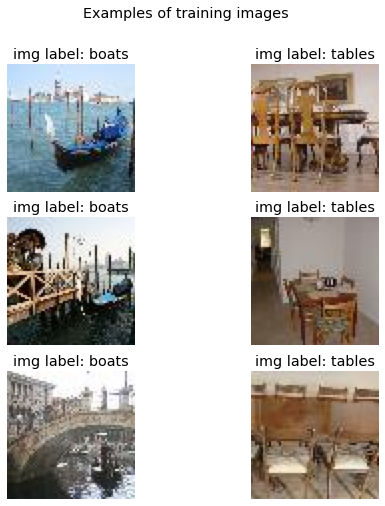

In [5]:
plot_sample_images(train_ds, n_images_per_class=3)

Let's now further pre-process the data and prepare for model training. The helper function `process_io` converts the normalized images into tensors and the labels to the indices 0 and 1 to train the classifier.

In [6]:
from typing import Tuple


def process_io(df: pd.DataFrame, labels: dict) -> Tuple[torch.Tensor, torch.Tensor]:
    x = df["normalized_images"]
    y = df["labels"]
    ds_label_to_model_label = {
        ds_label: idx for idx, ds_label in enumerate(labels.values())
    }
    x_nn = torch.stack(x.tolist()).to(DEVICE)
    y_nn = torch.tensor([ds_label_to_model_label[yi] for yi in y], device=DEVICE)
    return x_nn, y_nn


train_x, train_y = process_io(train_ds, label_names)
val_x, val_y = process_io(val_ds, label_names)
test_x, test_y = process_io(test_ds, label_names)

## Model definition and training

We use a ResNet18 from `torchvision` with final layers modified for binary classification.

Training for influence computation is facilitated by `:class:~pydvl.influence.model_wrappers.torch_wrappers.TorchModel`, a convenience wrapper around torch models which is part of pyDVL. We wrap this with a simple class `TrainingManager` which transparently handles persistence after training. The latter is not part of the main pyDVL package but just a way to reduce clutter in this notebook.

We train the model for 50 epochs and save the results. Then we plot the train and validation loss curves.

In [7]:
from torch import nn
from notebooks.notebook_support import TrainingManager, MODEL_PATH, new_resnet_model

model_ft = new_resnet_model(output_size=len(label_names))
mgr = TrainingManager(
    "model_ft",
    model_ft,
    nn.CrossEntropyLoss(),
    train_x,
    train_y,
    val_x,
    val_y,
    MODEL_PATH,
)
# Set use_cache=False to retrain the model
train_loss, val_loss = mgr.train(n_epochs=50, use_cache=True)

ModuleNotFoundError: No module named 'notebooks'

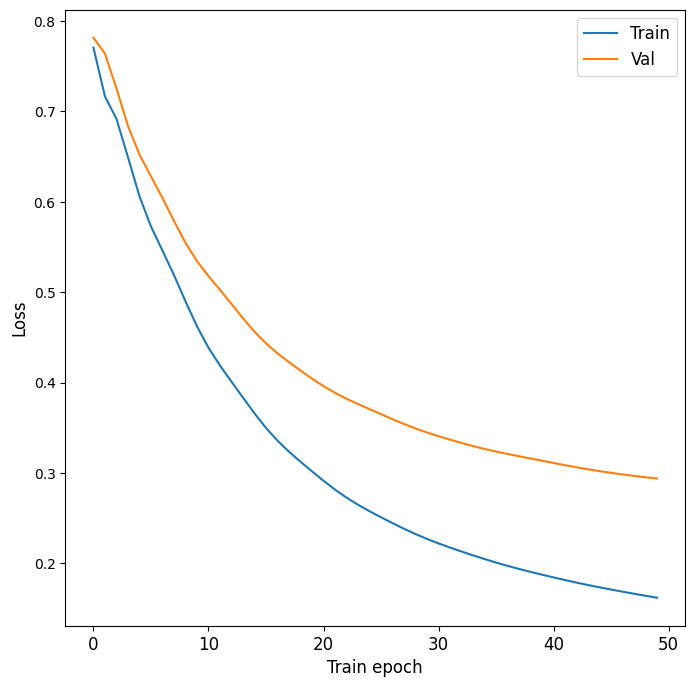

In [ ]:
plot_losses(train_loss, val_loss)

The confusion matrix and $F_1$ score look good, especially considering the low resolution of the images and their complexity (they contain different objects)

f1_score of model: 0.8776531889351485


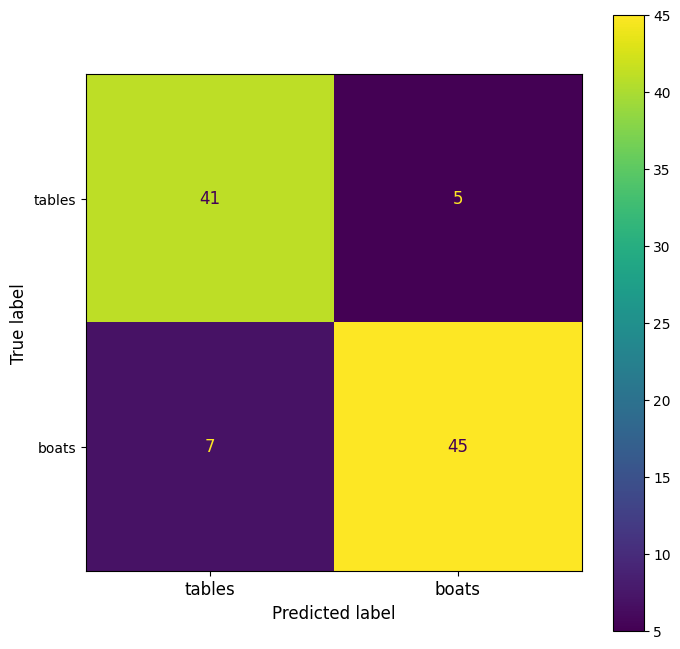

In [ ]:
pred_y_test = np.argmax(model_ft(test_x).detach(), axis=1)
model_score = f1_score(test_y, pred_y_test, average="weighted")

cm = confusion_matrix(test_y, pred_y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names.values())
print("f1_score of model:", model_score)
disp.plot();

## Influence computation

Let's now calculate influences! The main method is `:func:~pydvl.influence.general.compute_influences`, which takes a trained `nn.Model`, the training loss, some input dataset with labels (which typically is the training data, or a subset of it) and some test data.

Other important parameters are the Hessian regularization term, which should be chosen as small as possible for the computation to converge (further details on why this is important can be found in the [Appendix](#appendix)).

Since Resnet18 is quite big, we pick conjugate gradient (`cg`) as the method for inversion of the Hessian. A naive computation would require a lot of memory. Finally, the influence type will be `up`. The other option, `perturbation`, is beyond the scope of this notebook, but more info can be found in the notebook [using the Wine dataset](influence_wine.ipynb) or in the documentation for pyDVL.

The output of `calculate_influences` is a matrix of size `test_set_length` x `training_set_length`. Each row represents a test data point, and each column a training data point, so that entry $(i,j)$ represents the influence of training point $j$ on test point $i$.

In [ ]:
influences = compute_influences(
    model=mgr.model,
    loss=mgr.loss,
    x=train_x,
    y=train_y,
    x_test=test_x,
    y_test=test_y,
    hessian_regularization=hessian_reg,
    inversion_method="cg",
    influence_type="up",
    progress=True,
)

Split Gradient:   0%|          | 0/98 [00:00<?, ?it/s]

Conjugate gradient:   0%|          | 0/98 [00:00<?, ?it/s]

Split Gradient:   0%|          | 0/707 [00:00<?, ?it/s]

## Analysing influences

With the computed influences we can study single images or all of them together:

### Influence on a single test image

Let's take any image in the test set:

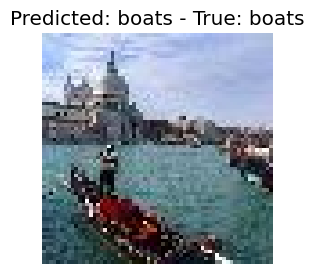

In [ ]:
test_image_idx = 42

model_label_to_ds_label = {
    idx: ds_label for idx, ds_label in enumerate(label_names.values())
}
predicted_label = model_label_to_ds_label[
    np.argmax(model_ft(test_x[test_image_idx].unsqueeze(0)).detach(), axis=1).item()
]
true_label = test_ds["labels"][test_image_idx]

plt.rcParams["figure.figsize"] = (3, 3)
plt.imshow(test_ds["images"][test_image_idx])
plt.axis("off")
plt.title(f"Predicted: {predicted_label} - True: {true_label}")
plt.show()

Now we plot the histogram of the influence that all training images have on the image selected above, separated by their label.

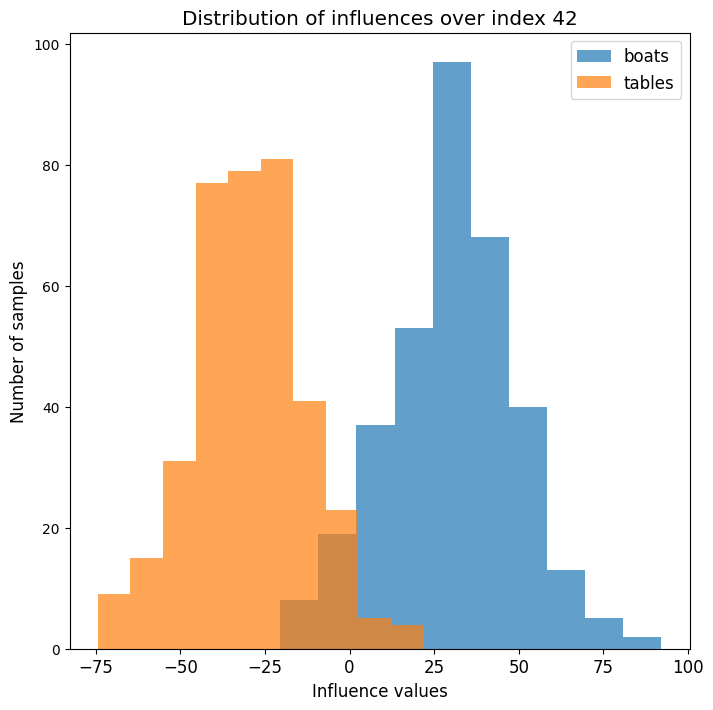

In [ ]:
plot_influence_distribution_by_label(
    influences[test_image_idx],
    train_ds["labels"].values,
    title_extra=f"over index {test_image_idx}",
)

Rather unsurprisingly, the training samples that have the same label as the test image have, on average, a higher influence on the classifier's output for it. Let's then take them and visualize those with the highest and lowest influence:

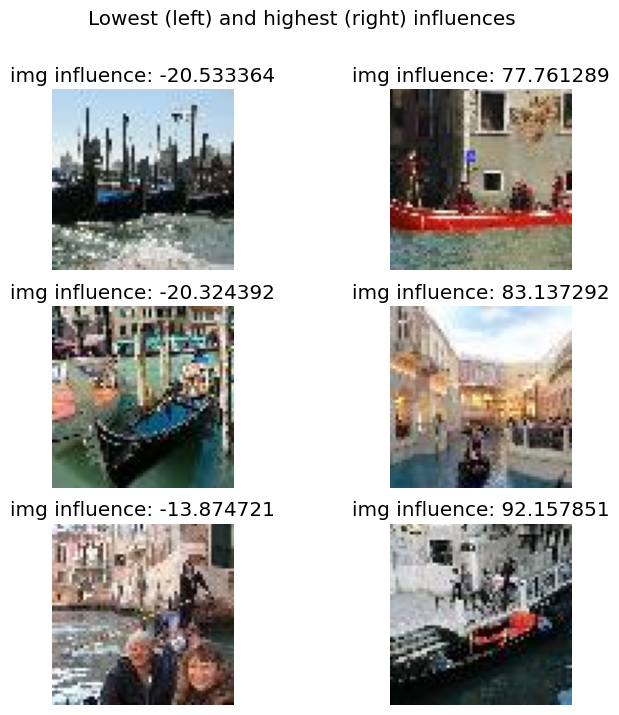

In [ ]:
images_with_same_label = train_ds["labels"] == test_ds["labels"][test_image_idx]
influence_values_with_same_label = influences[test_image_idx][images_with_same_label]
images_same_label = train_ds["images"][images_with_same_label].values
plot_lowest_highest_influence_images(
    influence_values_with_same_label, subset_images=images_same_label, num_to_plot=3
)

Looking at the images, it is difficult to explain why those on the right are more influential than those on the left. At first sight, the choice seems to be random (or at the very least noisy). Let's dig in a bit more by looking at average influences:

### Analysing the average influence on test samples

By averaging across the rows of the influence matrix, we obtain the average influence of each training sample on the whole test set:

In [ ]:
avg_influences = np.mean(influences, axis=0)

Once again, let's plot the histogram of influence values by label.

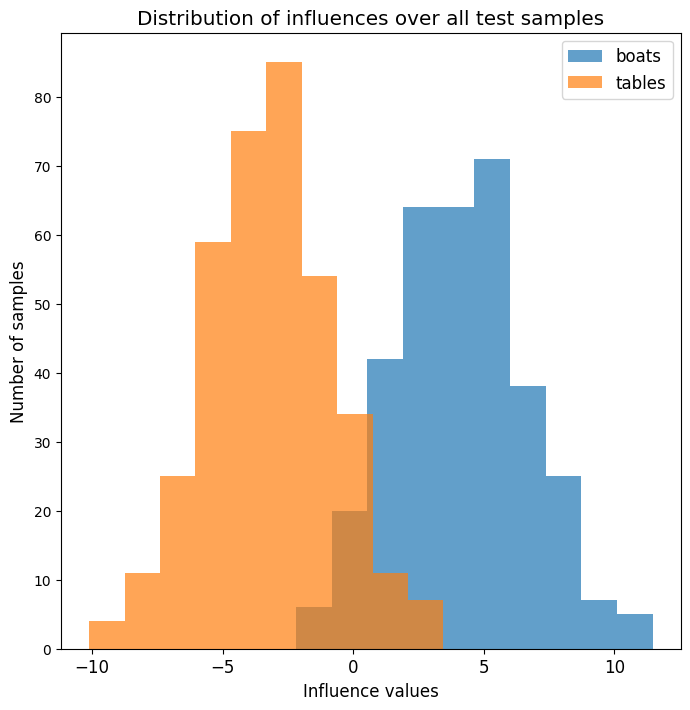

In [ ]:
plot_influence_distribution_by_label(
    avg_influences, train_ds["labels"].values, "over all test samples"
)

Next, for each class (you can change value by changing label key) we can have a look at the top and bottom images by average influence, i.e. we can show the images that have the highest and lowest average influence over all test images.

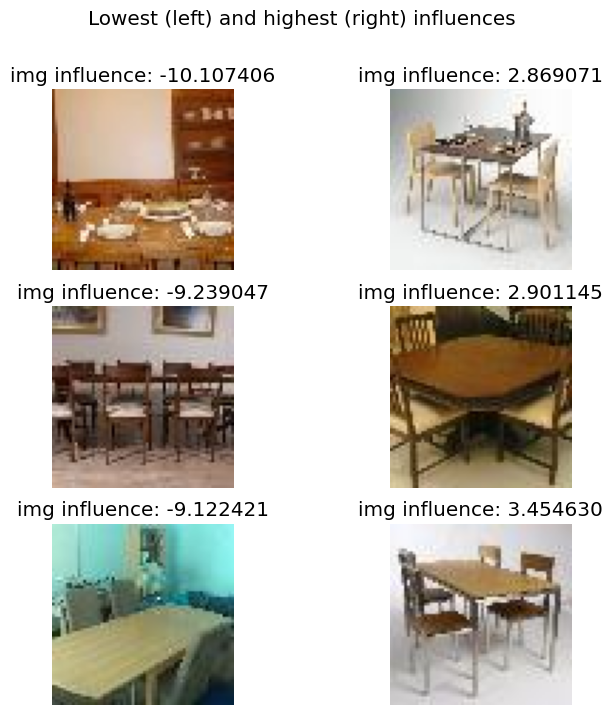

In [ ]:
label = "tables"
img_with_selected_label = train_ds["labels"] == label
if_selected_label = avg_influences[img_with_selected_label]
imges_same_label = train_ds["images"][img_with_selected_label].values
plot_lowest_highest_influence_images(if_selected_label, imges_same_label, num_to_plot=3)

Once again, it is not easy to explain why the images on the left have a lower influence than the ones on the right. One could argue that in order to predict that there is a dining table in the image it is beneficial to clearly see both the chairs and the table itself, a feature missing in some samples on the left. Also, color seems to be a discriminant: houses with a blue painting could get confused with the water around a boat. Of course, this is debatable and different people could come up with other explanations *a posteriori*.

## Detecting corrupted data

After facing the shortcomings of influence functions for explaining decisions, we move to an application with clear-cut results. Influences can be successfully used to detect corrupted or mislabeled samples, making them an effective tool to "debug" training data.

We begin by training a new model (with the same architecture as before) on a dataset with some corrupted labels. The method `get_corrupted_imagenet` will take the training dataset and corrupt a certain fraction of the labels by flipping them. We use the same number of epochs and optimizer as before.

In [ ]:
corrupted_model = new_resnet_model(output_size=len(label_names))
corrupted_dataset, corrupted_indices = corrupt_imagenet(
    dataset=train_ds,
    fraction_to_corrupt=0.1,
    avg_influences=avg_influences,
)

corrupted_train_x, corrupted_train_y = process_io(corrupted_dataset, label_names)

mgr = TrainingManager(
    "corrupted_model",
    corrupted_model,
    nn.CrossEntropyLoss(),
    corrupted_train_x,
    corrupted_train_y,
    val_x,
    val_y,
    MODEL_PATH,
)
training_loss, validation_loss = mgr.train(n_epochs=50, use_cache=True)

No pretrained model found. Training for 50 epochs:


Model fitting:   0%|          | 0/50 [00:00<?, ?it/s]

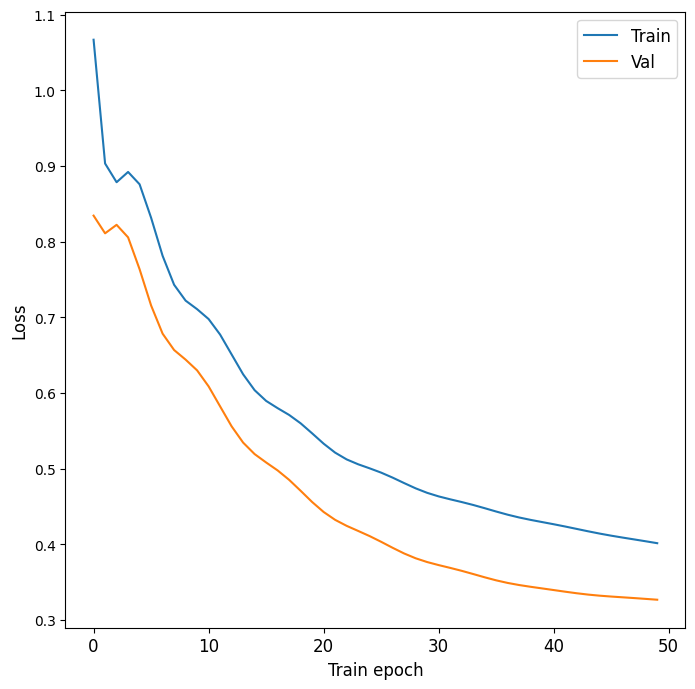

In [ ]:
plot_losses(training_loss, validation_loss)

In [ ]:
pred_y_test = np.argmax(corrupted_model(test_x).detach(), axis=1)
model_score = f1_score(test_y, pred_y_test, average="weighted")
print("F1 score of model with corrupted data:", model_score)

F1 score of model with corrupted data: 0.8672502428025255


Interestingly, despite being trained on a corrupted dataset, the model has a fairly high $F_1$ score. Let's now calculate the influence of the corrupted training data points over the test data points.

In [ ]:
influences = compute_influences(
    model=mgr.model,
    loss=mgr.loss,
    x=corrupted_train_x,
    y=corrupted_train_y,
    x_test=test_x,
    y_test=test_y,
    hessian_regularization=hessian_reg,
    inversion_method="cg",
    influence_type="up",
    progress=True,
)

Split Gradient:   0%|          | 0/98 [00:00<?, ?it/s]

Conjugate gradient:   0%|          | 0/98 [00:00<?, ?it/s]

Split Gradient:   0%|          | 0/707 [00:00<?, ?it/s]

As before, since we are interested in the average influence on the test dataset, we take the average of influences across rows, and then plot the highest and lowest influences for a chosen label

In [ ]:
avg_corrupted_influences = np.mean(influences, axis=0)

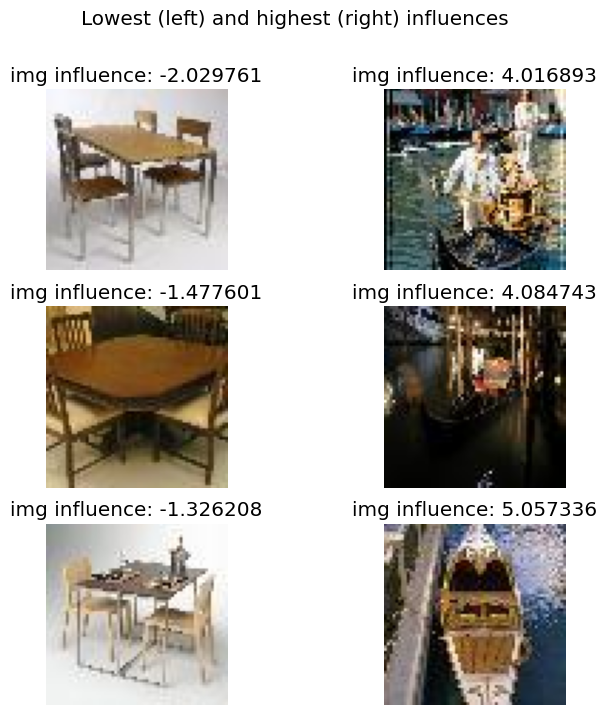

In [ ]:
label = "boats"
img_with_selected_label = corrupted_dataset["labels"] == label
if_selected_label = avg_corrupted_influences[img_with_selected_label]
imges_same_label = corrupted_dataset["images"][img_with_selected_label].values
plot_lowest_highest_influence_images(if_selected_label, imges_same_label, num_to_plot=3)

As expected, the samples with lowest (negative) influence for the label "boats" are those that have been corrupted: all the images on the left are tables! We can compare the average influence of corrupted data with non-corrupted ones

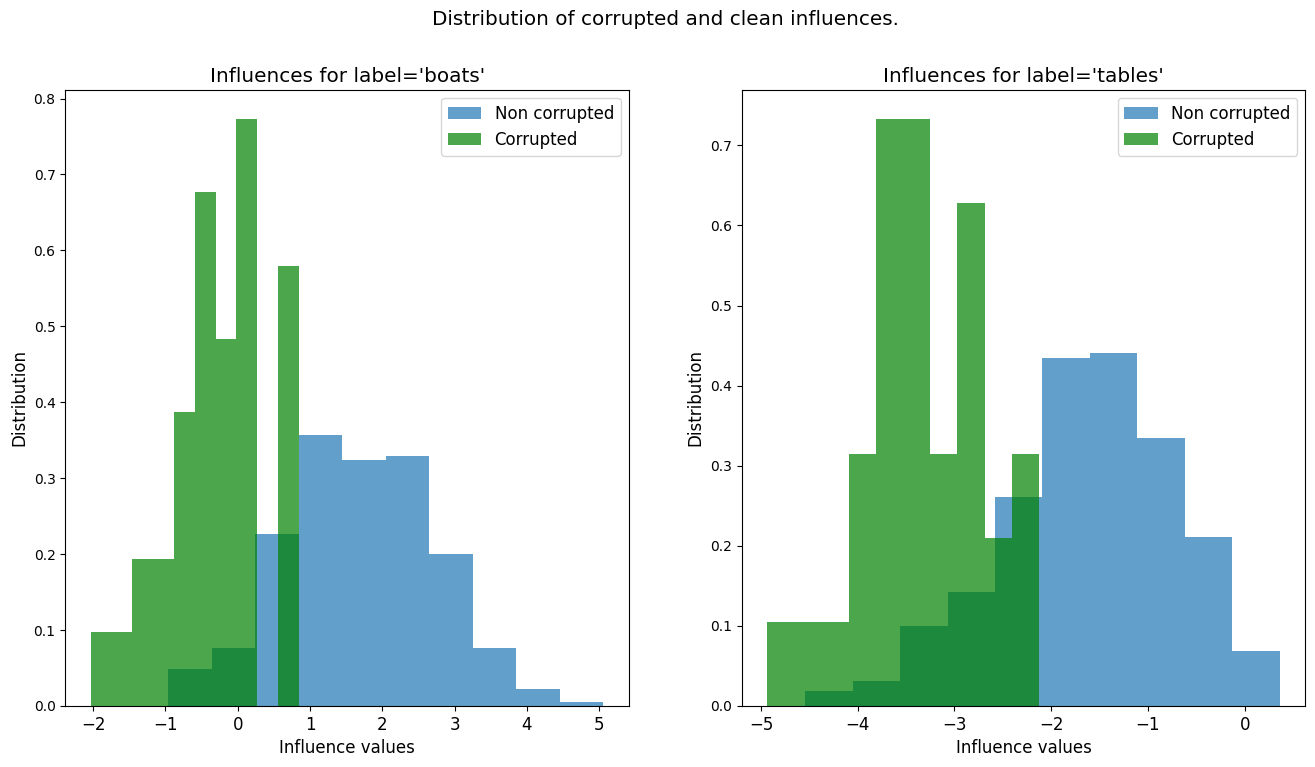

In [ ]:
plot_corrupted_influences_distribution(
    corrupted_dataset, corrupted_indices, avg_corrupted_influences
)

In [ ]:
compute_mean_corrupted_influences(
    corrupted_dataset, corrupted_indices, avg_corrupted_influences
)

,label,avg_non_corrupted_infl,avg_corrupted_infl,score_diff
0,boats,1.701271,-0.262438,1.963709
1,tables,-1.603050,-3.327871,1.724821


And indeed corrupted data have a more negative influence on average than clean ones!

Despite this being a useful property, influence functions are known to be unreliable for tasks of data valuation, especially in deep learning where the fundamental assumption of the theory (convexity) is grossly violated. A lot of factors (e.g. the size of the network, the training process or the Hessian regularization term) can interfere with the computation, to the point that often the results that we obtain cannot be trusted. This has been extensively studied in the recent paper:

*Basu, S., P. Pope, and S. Feizi. [Influence Functions in Deep Learning Are Fragile.](https://par.nsf.gov/servlets/purl/10315557) International Conference on Learning Representations (ICLR). 2021*.

Nevertheless, influence functions offer a relatively quick and mathematically rigorous way to evaluate (at first order) the importance of a training point for a model's prediction.

# Theory of influence functions for neural networks

In this appendix we will briefly go through the basic ideas of influence functions adapted for neural networks as introduced in *Koh, Pang Wei, and Percy Liang. ["Understanding Black-box Predictions via Influence Functions"](https://arxiv.org/pdf/1703.04730.pdf) International conference on machine learning. PMLR, 2017.*

Note however that this paper departs from the standard and established theory and notation for influence functions. For a rigorous introduction to the topic we recommend classical texts like *Hampel, Frank R., Elvezio M. Ronchetti, Peter J. Rousseeuw, and Werner A. Stahel. Robust Statistics: The Approach Based on Influence Functions. 1st edition. Wiley Series in Probability and Statistics. New York: Wiley-Interscience, 2005. https://doi.org/10.1002/9781118186435.*

## Upweighting points

Let's start by considering some input space $\mathcal{X}$ to a model (e.g. images) and an output space $\mathcal{Y}$ (e.g. labels). Let's take $z_i = (x_i, y_i)$ to be the $i$-th training point, and $\theta$ to be the (potentially highly) multi-dimensional parameters of the neural network (i.e. $\theta$ is a big array with very many parameters). We will indicate with $L(z, \theta)$ the loss of the model for point $z$ and parameters $\theta$. When training the model we minimize the loss over all points, i.e. the optimal parameters are calculated through gradient descent on the following formula:
$$
\hat{\theta} = \arg \min_\theta \frac{1}{n}\sum_{i=1}^n L(z_i, \theta)
$$
where $n$ is the total number of training data points.

For notational  convenience, let's define
 $$
\hat{\theta}_{-z} = \arg \min_\theta \frac{1}{n}\sum_{z_i \ne z} L(z_i, \theta) \ ,
$$
i.e. $\hat{\theta}_{-z}$ are the model parameters that minimize the total loss when $z$ is not in the training dataset.

In order to check the impact of each training point on the model, we would need to calculate $\hat{\theta}_{-z}$ for each $z$ in the training dataset, thus re-training the model at least ~$n$ times (more if model training is noisy). This is computationally very expensive, especially for big neural networks. To circumvent this problem, we can just calculate a first order approximation of $\hat{\theta}$. This can be done through single backpropagation and without re-training the full model.

Let's define
$$
\hat{\theta}_{\epsilon, z} = \arg \min_\theta \frac{1}{n}\sum_{i=1}^n L(z_i, \theta) + \epsilon L(z, \theta) \ ,
$$
which is the optimal $\hat{\theta}$ if we were to up-weigh $z$ by an amount $\epsilon$.

From a classical result (a simple derivation is available in Appendix A of Koh and Liang's paper), we know that:
$$
\frac{d \ \hat{\theta}_{\epsilon, z}}{d \epsilon} \Big|_{\epsilon=0} = -H_{\hat{\theta}}^{-1} \nabla_\theta L(z, \hat{\theta})
$$
where $H_{\hat{\theta}} = \frac{1}{n} \sum_{i=1}^n \nabla_\theta^2 L(z_i, \hat{\theta})$ is the Hessian of $L$. Importantly, notice that this expression is only valid when $\hat{\theta}$ is a minimum of $L$, or otherwise $H_{\hat{\theta}}$ cannot be inverted!

## Approximating the influence of a point

We will define the influence of training point $z$ on test point $z_{\text{test}}$ as $\mathcal{I}(z, z_{\text{test}}) =  L(z_{\text{test}}, \hat{\theta}_{-z}) - L(z_{\text{test}}, \hat{\theta})$ (notice that it is higher for points $z$ which positively impact the model score, since if they are excluded, the loss is higher). In practice, however, we will always use the infinitesimal approximation $\mathcal{I}_{up}(z, z_{\text{test}})$, defined as
$$
 \mathcal{I}_{up}(z, z_{\text{test}}) = - \frac{d L(z_{\text{test}}, \hat{\theta}_{\epsilon, z})}{d \epsilon} \Big|_{\epsilon=0}
$$

Using the chain rule and the results calculated above, we thus have:

$$
 \mathcal{I}_{up}(z, z_{\text{test}}) = - \nabla_\theta L(z_{\text{test}}, \hat{\theta})^\top \ \frac{d \hat{\theta}_{\epsilon, z}}{d \epsilon} \Big|_{\epsilon=0} = \nabla_\theta L(z_{\text{test}}, \hat{\theta})^\top \ H_{\hat{\theta}}^{-1} \ \nabla_\theta L(z, \hat{\theta})
$$

In order to calculate this expression we need the gradient and the Hessian of the loss wrt. the model parameters $\hat{\theta}$. This can be easily done through a single backpropagation pass.

## Regularizing the Hessian

One very important assumption that we make when approximating influence is that $\hat{\theta}$ is at least a local minimum of the loss. However, we clearly cannot guarantee this except for convex models, and despite good apparent convergence, $\hat{\theta}$ might be located in a region with flat curvature or close to a saddle point. In particular, the Hessian might have vanishing eigenvalues making its direct inversion impossible.

To circumvent this problem, instead of inverting the true Hessian $H_{\hat{\theta}}$, one can invert a small perturbation thereof: $H_{\hat{\theta}} + \lambda \mathbb{I}$, with $\mathbb{I}$ being the identity matrix. This standard trick ensures that the eigenvalues of $H_{\hat{\theta}}$ are bounded away from zero and therefore the matrix is invertible. In order for this regularization not to corrupt the outcome too much, the parameter $\lambda$ should be as small as possible while still allowing a reliable inversion of $H_{\hat{\theta}} + \lambda \mathbb{I}$.
